![title](figure_1_burr_settles.png)    

Fig 1 Credit: Burr Settles. 2009. “Active Learning Literature Survey.” Computer Sciences Technical Report 1648. University of Wisconsin–Madison.


This Notebook demonstrates the process of Active Learning (AL) using features from the Stanford movies review dataset (http://ai.stanford.edu/~amaas/data/sentiment/) following the CRISP-DM process (https://paginas.fe.up.pt/~ec/files_0405/slides/02%20CRISP.pdf).  


**Statement of Business Objective**

The business would like to gain more value from unstructured text data while optimizing use of labor resources.  This project specifically aims to answer if rationales aid in active learning. Labeling uses resources and active learning attempts to add value by reducing the resources needed to construct models. 

Thus this effort asks three questions:  
1) Does active learning with rationales reduce the labeling effort against a baseline effort?   
2) If so, by how much (show AUC)? 
3) If so, what balance between the rationale and baseline document features (represented by c) optimizes this reduction?

**Statement of Machine Learning Objective**

The machine learning system should enable the business to indepententy generate concepts and perform classification on their own data.  The system will use AL to deliver increased value from unstructured data.

AL accomplishes this through an iterative process that trains on the labeled features and then predicts on the unlabeled samples' features.  These predictions can then be evaluated in a manner to suggest the next desirable review for the expert to label.  

For example, ordering based on distance from the classification boundary allows prioritization of the sample that may be questionable.  Once labeled, the iterative process repeats, the labeled features are used to train the model, and predictions are evaluated to provide the next sample(s) for labeling.

**Statement of Success Criteria**  

AL is a process that relies on an expert's feedback to label samples and drive the machine learning process.  The benefit of Active Learning with Rationales is to learn a model of the concept (in this case sentiment) in a manner that further minimizes the need for the expert's time (resources).  Thus this effort will show the advantage of using rationales to reduce the need for business resources.

Highlights at some c (range 0.0 to 1) should exceed the max baseline performance metric by 5%.

**Data Understanding** 

In the case of sentiment (as the concept), the positive and negative labels simply a boolean value for each sample.  Here is a positive sentiment sample from the movie review dataset:
    

**[train/pos/1999_9.txt]**   
*Oliver! the musical is a favorite of mine. The music, the characters, the story. It all just seems perfect. In this rendition of the timeless classic novel turned stage musical, director Carol Reed brings the Broadway hit to life on the movie screen.<br /><br />The transition from musical to movie musical is not an easy one. You have to have the right voices, the right set, the right script, and the right play. All signs point to yes for this play. It almost appears that it was written for the screen!<br /><br />Our story takes place in jolly old England where a boy named Oliver manages to work his way out of the orphanage. He winds his way through the country to London where he meets up with a group of juvenile delinquents, headed by Dodger, the smart talking, quick handed pick-pocket. The leader of this gang is named Fagin, an older fellow who sells all the stolen goods.<br /><br />But all is not well in London town when Bill Sykes played by Oliver Reed and his loving girlfriend Nancy get tangled up with Oliver, Fagin and his young troops, and the law. What ensues is a marvelous tale of love, affection, and great musical numbers.<br /><br />Whether or not you like musicals or not, one listen to these tunes and you will be humming them all day long. Oliver! is a triumph on and off the stage and is a timeless work of art.*

Pymagnitude is used to generate 300 float value features for the above text.  These particular features represent the positive movie review for *Oliver!*. 

Lets cover how these 300 features are generated.  Each word in the document is used to find its **word2vec** feature, and then these features are averaged to produce the above document-level feature.  Services like **pymagnitude** are used to create the 300 floats for each word using the query method.  Then, for each document, these are averaged. 

**Data Preparation**

The movie review data dataset does not have rationales.  Amazon's Mechanical Turk provides a way to gather the rationales for both the positive and negative reviews.  The first acceptable rationale for each review is selected for a balanced number of postive and negative samples.  A pretrained word2vec model is used to generate word level features embeddings.  Then these results are saved for the next stage since they are used many times (as seen later for grid search and shuffle processing).

Here is the source code for filtering the input data:

In [1]:
!cat process_step_1_read_split_save.py


import pandas as pd
import random
import numpy as np
import pickle

# load data
pos_df = pd.read_csv('../../../Downloads/Batch_3494319_batch_results.csv')
neg_df = pd.read_csv('../../../Downloads/Batch_3494476_batch_results.csv')

# only get the accepted records from the mechanical turk results
pos_df_approved = pos_df[pos_df['AssignmentStatus']=='Approved']
neg_df_approved = neg_df[neg_df['AssignmentStatus']=='Approved']

# get a balanced set of highlighted postive and negative reviews
pos_df_approved = pos_df_approved.drop_duplicates(subset='Input.text', keep='first')
neg_df_approved = neg_df_approved.drop_duplicates(subset='Input.text', keep='first')
balanced_count = min(len(pos_df_approved), len(neg_df_approved))

# buid the dataset to contain the 
labeled_pos = random.sample(pos_df_approved['Answer.highlights'].tolist(), balanced_count)
labeled_neg = random.sample(neg_df_approved['Answer.highlights'].tolist(), balanced_count)

# here, negative is mapped to zere and positive to on

Here is the source code for finding and saving the features:

In [2]:
!cat process_step_2_assign_features.py

import pickle
import numpy as np
import pymagnitude

# load input data
X = pickle.load( open('X.pkl', 'rb') )

# load the pretrained word2vec model for feature assignment
pretrained_magnitude = r'../../../Downloads/pretrained/glove.6B.300d.magnitude'
vectors = pymagnitude.Magnitude(pretrained_magnitude)

# setup speciality cleaning
def get_document_features(data_in):
    """Used to clean 80k Mechanical Turk responses.

    Params:
        data_in --  text segment to process
    Returns:
        features for input text and features
    """
    data_in = data_in.replace('<span class=\"active_text\">', '').replace('</span>', '')
    body = data_in.split(r'\n                                    ')[1].replace('\n', '')
    avg_vec = np.mean(vectors.query(body.split(' ')), axis=(0))

    high_text = data_in.split(r'\n                                    ')[0].replace('\n', '')
    high_avg_vec = np.mean(vectors.query(high_text.split(' ')), axis=(0))
    return avg_vec,  high_avg_vec
        
#

**Modeling**

We want to first find the baseline performance metrics.  We do this to find the best AUC performance of .82

In [3]:
!cat process_step_3_baseline.py

# open the upstream data
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

# import the feature data and labels
Y = pickle.load(  open('Y.pkl', "rb" ) )
X_reg_features = pickle.load(  open('X_reg_features.pkl', "rb" ) )

# split the dataset
X_train_reg, X_test_reg, Y_train_reg, Y_test_reg = train_test_split(X_reg_features, Y, test_size=0.2)

# Train each model
reg_model = LogisticRegression().fit(X_train_reg, Y_train_reg)

# find AUC for baseline
reg_probas_ = reg_model.decision_function(X_test_reg)
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test_reg, reg_probas_)
print( auc(false_positive_rate, true_positive_rate) ) 

In [4]:
!cat process_step_4_train_score_auc.py

# open the upstream data
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score
import numpy as np
import pandas as pd


SEED = 0 #64

def find_nearest(array, value):
    """Finds the prediction closest to the boundary"""
    array = np.asarray(array)
    return (np.abs(array - value)).argmin()

# different values of c (.1 increments)
for c in [0.9]:#[0.5,0.2,0.8,0.4,0.6,0.7,0.3,0.9,0.1,0.0,1.0]:
    # import the feature data and labels
    Y = pickle.load(  open('Y.pkl', "rb" ) )
    X_reg_features = pickle.load(  open('X_reg_features.pkl', "rb" ) )
    X_high_features = pickle.load(  open('X_high_features.pkl', "rb" ) )

    # apply c to show how different proportions impact AL performance
    for idx,baseline_feats in enumerate(X_reg_features):
        X_high_features[idx] =  (X_high_features[idx] * c) + (1-c) * baseline_feats

    # reshuffle 20 

**Evaluation**

Here we find that the baseline performance is exceeded by over 5% for c=0.9.  The following code generates the baseline and highlight performance plots for each c at 0.1 intervals.  A higher C represents more highlight feature weighting.  

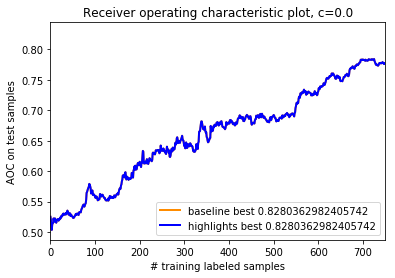

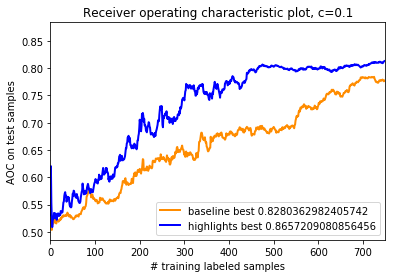

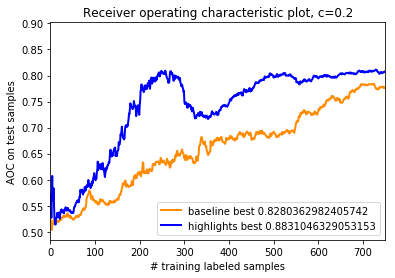

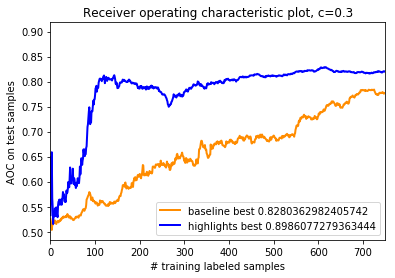

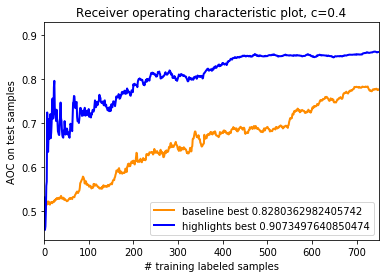

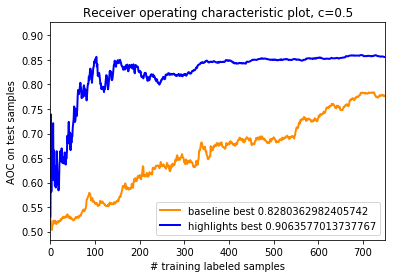

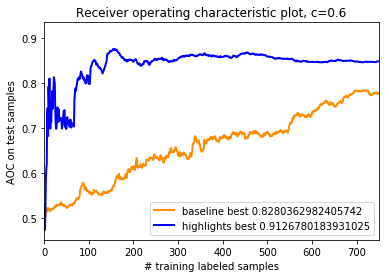

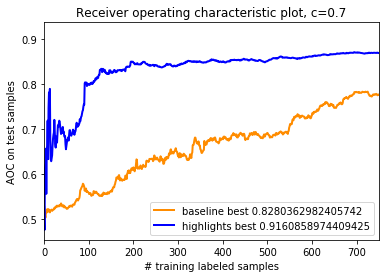

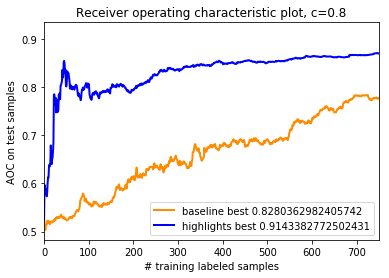

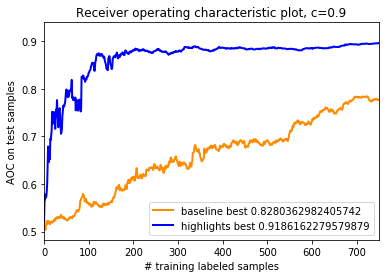

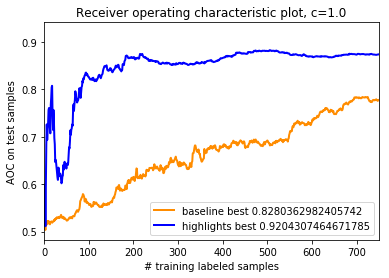

In [5]:
# Compute ROC curve and ROC area for each class
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pickle

for c in [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
    # get the file
    high_auc = pickle.load(  open('high_auc_'+str(c)+'_1.pkl', "rb" ) )
    norm_auc = pickle.load(  open('norm_auc_'+str(c)+'_1.pkl', "rb" ) )
    best_high = max(high_auc)
    best_base = max(norm_auc)
    
    plt.figure()
    lw = 2
    plt.plot(norm_auc,color='darkorange',lw=lw, label='baseline best ' + str(best_base) )
    plt.plot(high_auc,color='blue',lw=lw, label='highlights best ' + str(best_high) )
    plt.xlim([0.0, 750.0])
    #plt.ylim([0.525, 0.55])
    plt.xlabel('# training labeled samples')
    plt.ylabel('AOC on test samples')
    plt.title('Receiver operating characteristic plot, c='+str(c))
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# we can also leverage tensorboard using tensorboardx
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tensorboardX import SummaryWriter

# generate c search viz first
for e in [1]:
    for c in [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
        writer = SummaryWriter('active_learning_c'+str(c))
        # get the file
        high_auc = pickle.load(  open('high_auc_'+str(c)+'_1.pkl', "rb" ) )
        norm_auc = pickle.load(  open('norm_auc_'+str(c)+'_1.pkl', "rb" ) )
        best_high = max(high_auc)
        best_base = max(norm_auc)
        
        for idx, baseline_auc in enumerate(norm_auc):
            writer.add_scalar('baseline/auc', baseline_auc, idx)
        for idx, highlight_auc in enumerate(high_auc):
            writer.add_scalar('highlight/auc', highlight_auc, idx, c)
        
        fig = plt.figure()
        lw = 2
        plt.plot(norm_auc,color='darkorange',lw=lw, label='baseline best ' + str(best_base) )
        plt.plot(high_auc,color='blue',lw=lw, label='highlights best ' + str(best_high) )
        #plt.xlim([0.0, 750.0])
        #plt.ylim([0.525, 0.55])
        plt.xlabel('# training labeled samples')
        plt.ylabel('AOC on test samples')
        plt.title('Receiver operating characteristic plot, c='+str(c))
        plt.legend(loc="lower right")
        #plt.show()
        writer.add_figure('Receiver operating characteristic plot, c='+str(c), fig)
        writer.close()


In [ ]:
# generate the 20x split/runs for c=0.9 
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tensorboardX import SummaryWriter

    
for e in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]:
    for c in [0.9]:
        writer = SummaryWriter('active_learning_pt9_'+str(e))
        # get the file
        high_auc = pickle.load(  open('high_auc_0.9_'+str(e)+'.pkl', "rb" ) )
        norm_auc = pickle.load(  open('norm_auc_0.9_'+str(e)+'.pkl', "rb" ) )
        best_high = max(high_auc)
        best_base = max(norm_auc)
        
        for idx, baseline_auc in enumerate(norm_auc):
            writer.add_scalar('baseline/auc', baseline_auc, idx)
        for idx, highlight_auc in enumerate(high_auc):
            writer.add_scalar('highlight/auc', highlight_auc, idx, c)
        
        fig = plt.figure()
        lw = 2
        plt.plot(norm_auc,color='darkorange',lw=lw, label='baseline best ' + str(best_base) )
        plt.plot(high_auc,color='blue',lw=lw, label='highlights best ' + str(best_high) )
        #plt.xlim([0.0, 750.0])
        #plt.ylim([0.525, 0.55])
        plt.xlabel('# training labeled samples')
        plt.ylabel('AOC on test samples')
        plt.title('Receiver operating characteristic plot, c='+str(c))
        plt.legend(loc="lower right")
        #plt.show()
        writer.add_figure('Receiver operating characteristic plot, c='+str(c), fig)
        writer.close()

You can further explore these results using TensorBoard as detailed in this project's README.

**Deployment**

This system is deployed inline with other knowledge value tools as it clearly demonstrates resource savings in comparison to offline machine learning methods.